# Control on Gym Cartpole

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathisfederico/controlgym/blob/master/notebooks/cartpole.ipynb)

# Setup

## Environment

In [1]:
try:
    import controlgym
except ImportError:
    !pip install git+https://github.com/MathisFederico/ControlGym.git

In [2]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate
!apt-get install -y ffmpeg

'apt-get' is not recognized as an internal or external command,
operable program or batch file.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


## Rendering

In [3]:
import sys
from controlgym.video import show_video, record_video

if not sys.platform.startswith('win32'):
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

# Experiments

In [4]:
from controlgym.envs.cartpole import FixedCartPoleEnv
from gym.wrappers.time_limit import TimeLimit
import numpy as np

upenv = FixedCartPoleEnv()
upenv.theta_threshold_radians = np.inf
upenv = TimeLimit(upenv, max_episode_steps=200)

## Start at equilibrium

### Random Agent

In [5]:
from controlgym.agents import RandomAgent
random_agent = RandomAgent(upenv.action_space)
observations, actions, times = record_video(upenv, random_agent, steptime=upenv.tau)
show_video()

89 89 89


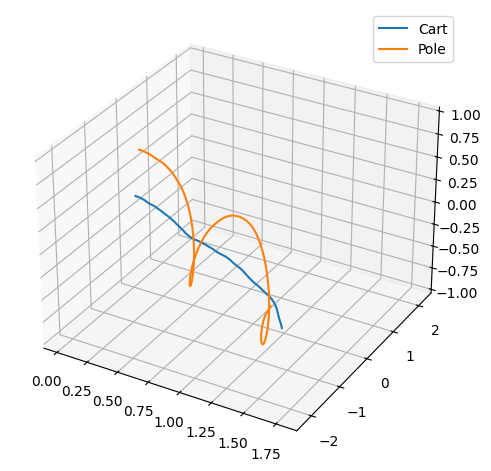

In [6]:
from controlgym.envs.cartpole import plot_cartpole_history
plot_cartpole_history(
    times,
    observations[:,0],
    observations[:, 2],
    upenv.length,
    upenv.x_threshold
)

### LQR Control

In [ ]:
from controlgym.envs.cartpole import get_cartpole_linear_model, get_cartpole_linear_lqr_gain


cartpole_linear_model = get_cartpole_linear_model(upenv)
cartpole_linear_model

<LinearIOSystem:sys[2]$sampled:['u[0]']->['y[0]', 'y[1]', 'y[2]', 'y[3]']>

In [ ]:
from numpy.linalg import matrix_rank as rank
import control.matlab as ctm

assert rank(ctm.ctrb(cartpole_linear_model.A, cartpole_linear_model.B)) == 4 # Ensure controlable system

K = get_cartpole_linear_lqr_gain(cartpole_linear_model)
K

array([[0.72484793, 1.02557377, 5.67704363, 1.91903972]])

In [13]:
from controlgym.agents.control import LinearControlAgent

class DiscreteLinearControlAgent(LinearControlAgent):
    def act(self, observation):
        continuous_action = LinearControlAgent.act(self, observation)
        return int(continuous_action[0] > 0)

control_agent = DiscreteLinearControlAgent(K)

record_video(upenv, control_agent)
show_video()

NameError: name 'K' is not defined

## Start at bottom position

In [10]:
from controlgym.envs.cartpole import CartPoleDownEnv

env = CartPoleDownEnv()
env = TimeLimit(env, max_episode_steps=200)

### Random agent

In [ ]:
record_video(env, random_agent)
show_video()

### LQR Control

In [ ]:
record_video(env, control_agent)
show_video()

### HEBG + LQR

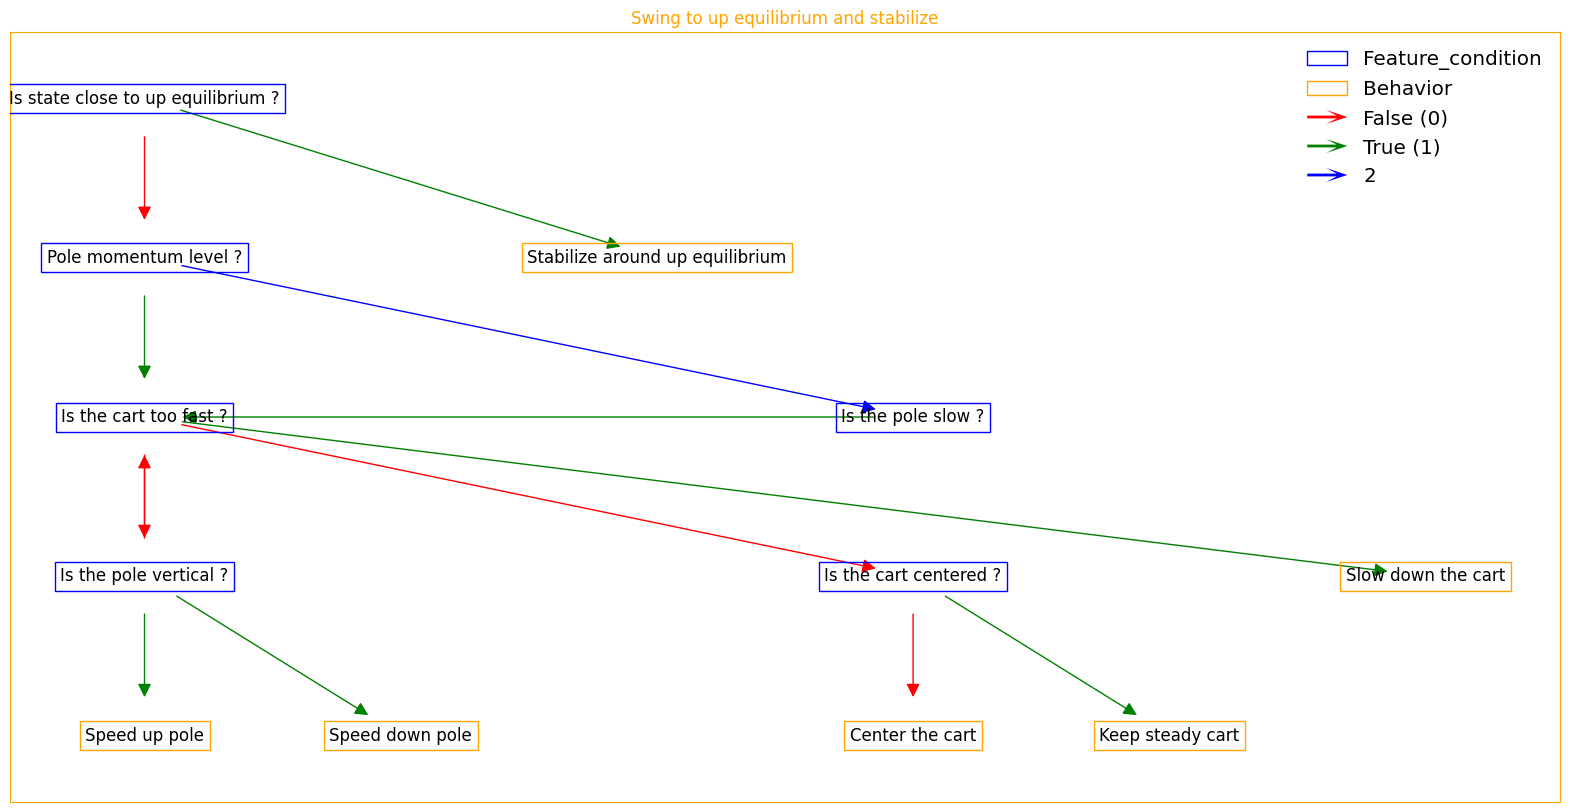

In [14]:
import control as ct

from hebg import HEBGraph, FeatureCondition, Behavior
from hebg.unrolling import unroll_graph

from controlgym.envs.cartpole import get_cartpole_linear_model
from controlgym.agents.control import LinearControlAgent

def get_cartpole_linear_lqr_gain(model: ct.StateSpace):
    Qx1 = np.diag([10, 1, 100, 1000])
    Qu1a = np.diag([0.1])
    K, _, _ = ct.lqr(model, Qx1, Qu1a)
    return np.array(K)


class DiscreteLinearControlAgent(LinearControlAgent):
    def act(self, observation):
        continuous_action = LinearControlAgent.act(self, observation)
        return int(continuous_action[0] > 0)


call_history = []

class KeepSteadyCart(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Keep steady cart")
        self.last_action = 0

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        self.last_action = 1 - self.last_action
        return self.last_action


class IsCartTooFast(FeatureCondition):
    def __init__(self) -> None:
        super().__init__(name="Is the cart too fast ?")

    def __call__(self, observation):
        x, x_dot, theta, theta_dot = observation
        return int(np.abs(x_dot) > 10 * env.force_mag * env.tau)


class SlowDownCart(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Slow down the cart")

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        x, x_dot, theta, theta_dot = observation
        return np.array(x_dot < 0, dtype=np.int32)


class CenterCart(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Center the cart")

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        x, x_dot, theta, theta_dot = observation
        return np.array(x < 0, dtype=np.int32)


class IsCartCentered(FeatureCondition):
    def __init__(self) -> None:
        super().__init__(name="Is the cart centered ?")

    def __call__(self, observation):
        x, x_dot, theta, theta_dot = observation
        return int(np.abs(x) < 0.85 * env.x_threshold)


class KeepSteadyCenteredCart(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Keep steady cart near the center")

    def build_graph(self) -> HEBGraph:
        graph = HEBGraph(self)

        cart_too_fast = IsCartTooFast()
        graph.add_edge(cart_too_fast, SlowDownCart(), index=1)

        cart_centered = IsCartCentered()
        graph.add_edge(cart_too_fast, cart_centered, index=0)
        graph.add_edge(cart_centered, CenterCart(), index=0)
        graph.add_edge(cart_centered, KeepSteadyCart(), index=1)

        return graph


class StabilizeAroundUpEquilibrium(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Stabilize around up equilibrium")
        model = get_cartpole_linear_model(env)
        K = get_cartpole_linear_lqr_gain(model)
        self.control_agent = DiscreteLinearControlAgent(K)

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        return self.control_agent.act(observation)


class IsPoleSlow(FeatureCondition):
    def __init__(self) -> None:
        super().__init__(name="Is the pole slow ?")

    def __call__(self, observation):
        x, x_dot, theta, theta_dot = observation
        return np.abs(theta_dot) < 0.5


class IsPoleVertical(FeatureCondition):
    def __init__(self) -> None:
        super().__init__(name="Is the pole vertical ?")

    def __call__(self, observation):
        x, x_dot, theta, theta_dot = observation
        return np.abs(np.sin(theta)) < 0.5


class SpeedDownPole(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Speed down pole")

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        x, x_dot, theta, theta_dot = observation
        return np.array(theta_dot * np.cos(theta) >= 0, dtype=np.int32)


class SpeedUpPole(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Speed up pole")

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        x, x_dot, theta, theta_dot = observation
        return np.array(theta_dot * np.cos(theta) < 0, dtype=np.int32)


class SteadySpeedDownPole(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Speed down pole with a steady cart")

    def build_graph(self) -> HEBGraph:
        graph = HEBGraph(self)
        is_pole_slow = IsPoleSlow()
        steady = KeepSteadyCenteredCart()
        graph.add_edge(is_pole_slow, steady, index=1)

        cart_too_fast = IsCartTooFast()
        graph.add_edge(is_pole_slow, cart_too_fast, index=0)
        graph.add_edge(cart_too_fast, SlowDownCart(), index=1)

        pole_vertical = IsPoleVertical()
        graph.add_edge(cart_too_fast, pole_vertical, index=0)
        graph.add_edge(pole_vertical, SpeedDownPole(), index=1)
        graph.add_edge(pole_vertical, steady, index=0)

        return graph


class SteadySpeedUpPole(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Speed up pole with a steady cart")

    def build_graph(self) -> HEBGraph:
        graph = HEBGraph(self)

        cart_too_fast = IsCartTooFast()
        graph.add_edge(cart_too_fast, SlowDownCart(), index=1)

        pole_vertical = IsPoleVertical()
        graph.add_edge(cart_too_fast, pole_vertical, index=0)
        graph.add_edge(pole_vertical, SpeedUpPole(), index=1)
        graph.add_edge(pole_vertical, KeepSteadyCenteredCart(), index=0)
        return graph


class PoleMomentumLevel(FeatureCondition):
    def __init__(self) -> None:
        super().__init__(name="Pole momentum level ?")
        self.g = env.gravity
        self.l = env.length
        self.m = env.masspole
        self.M = env.masscart

    def __call__(self, observation):
        x, x_dot, theta, theta_dot = observation
        normed_theta = (theta + np.pi) % (2 * np.pi) - np.pi
        z = np.cos(normed_theta) + 1
        energy = (
            (self.M + self.m) * np.square(x_dot) / 2
            + self.m * np.square(self.l * theta_dot) / 2
            + self.m * self.l * z * x_dot * theta_dot
            + self.m * self.g * self.l * z
        )
        required_potential_inertia = 2 * self.m * self.g * self.l
        if energy < 1.0 * required_potential_inertia:
            return 0  # Too slow
        if energy > 1.1 * required_potential_inertia:
            return 2  # Too fast
        return 1


class SwingToUpEquilibrium(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Swing to up equilibrium")

    def build_graph(self) -> HEBGraph:
        graph = HEBGraph(self)
        inertia_level = PoleMomentumLevel()
        graph.add_edge(inertia_level, SteadySpeedUpPole(), index=0)
        graph.add_edge(inertia_level, SteadySpeedDownPole(), index=2)
        graph.add_edge(inertia_level, KeepSteadyCenteredCart(), index=1)
        return graph


class IsCloseToUpEquilibrium(FeatureCondition):
    def __init__(self) -> None:
        super().__init__(name="Is state close to up equilibrium ?")

    def __call__(self, observation):
        x, x_dot, theta, theta_dot = observation
        normed_theta = (theta + np.pi) % (2 * np.pi) - np.pi
        close_in_theta = np.abs(normed_theta) < np.pi / 3
        next_theta = normed_theta + theta_dot * 5 * env.tau
        not_too_fast =  np.abs(theta_dot) < 10 * env.force_mag * env.tau
        close_in_next_theta = np.abs(next_theta) < np.pi / 6
        return close_in_next_theta and close_in_theta and not_too_fast


class SwingUpAndStabilize(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Swing to up equilibrium and stabilize")

    def build_graph(self) -> HEBGraph:
        graph = HEBGraph(self)
        is_close_to_up_eq = IsCloseToUpEquilibrium()
        graph.add_edge(is_close_to_up_eq, SwingToUpEquilibrium(), index=int(False))
        graph.add_edge(
            is_close_to_up_eq, StabilizeAroundUpEquilibrium(), index=int(True)
        )
        return graph

swing_up_behavior = SwingUpAndStabilize()

# Obtain networkx graph
graph = swing_up_behavior.graph

# Draw graph using matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[20, 10], dpi=100)
unrolled_graph = unroll_graph(graph, add_prefix=False)
unrolled_graph.draw(ax)
plt.show()

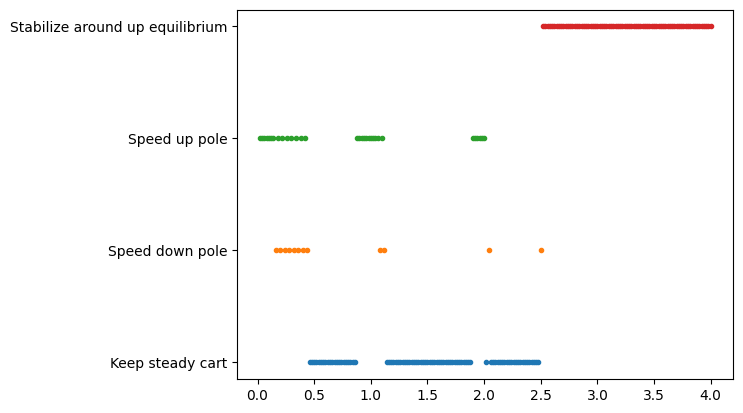

200 200 200


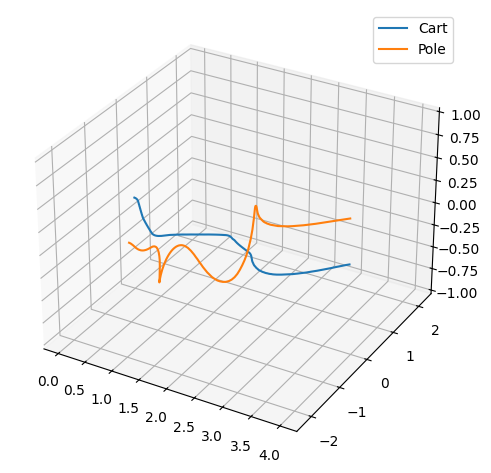

In [25]:
from controlgym.agents import HEBGAgent
from controlgym.plotting import plot_hebg_call_history

swing_up_hebg_agent = HEBGAgent(swing_up_behavior)
call_history = []
observations, actions, times = record_video(env, swing_up_hebg_agent, steptime=env.tau)
plot_hebg_call_history(times, call_history)
show_video()
plot_cartpole_history(
    times,
    observations[:,0],
    observations[:, 2],
    env.length,
    env.x_threshold
)

### MPC Control

In [ ]:
import control as ct
import control.optimal as obc
from controlgym.envs.cartpole import cartpole_rhs

io_cartpole = ct.NonlinearIOSystem(
    updfcn=cartpole_rhs, outfcn=None, inputs=('u'), dt=env.tau,
    outputs=(r'$x$', r'$\dot x$', r'$\theta$', r'$\dot\theta$'),
    states=(r'$x$', r'$\dot x$', r'$\theta$', r'$\dot\theta$'),
    name='pendulum',
    params={
        'dt': env.tau,
        'gravity': env.gravity,
        'length': env.length,
        'masspole': env.masspole,
        'total_mass': env.total_mass,
        'polemass_length': env.polemass_length,
        'force_mag': env.force_mag,
    },
)
print(io_cartpole, f"\nSampling time: {io_cartpole.dt}")

<NonlinearIOSystem>: pendulum
Inputs (1): ['u']
Outputs (4): ['$x$', '$\\dot x$', '$\\theta$', '$\\dot\\theta$']
States (4): ['$x$', '$\\dot x$', '$\\theta$', '$\\dot\\theta$']

Update: <function cartpole_rhs at 0x000002537FB7CF70>
Output: None 
Sampling time: 0.02


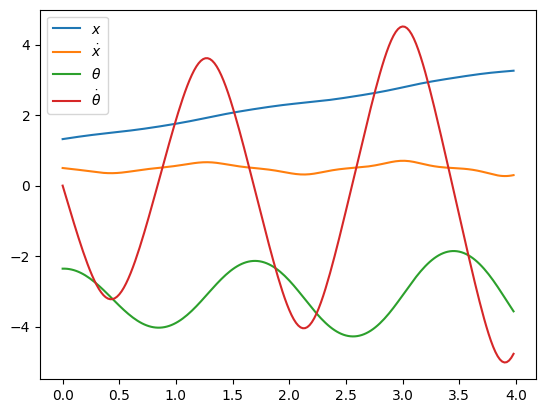

In [ ]:
from controlgym.envs.cartpole import plot_cartpole_history
import numpy as np
import matplotlib.pyplot as plt

X0 = [0.55*env.x_threshold, 0.5, - np.pi + np.pi / 4, 0]
T = np.arange(200) * env.tau
U = np.zeros_like(T)

# Simulate the system
t, y = ct.input_output_response(io_cartpole, T, U, X0)

for mesure, name in zip(y, io_cartpole.output_labels):
    plt.plot(t, mesure, label=name)


plt.legend()
plt.show()

0.2 0.2


d:\Data\Projects\Github\Recherche\ControlGym\venv\lib\site-packages\control\optimal.py:928: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(


Summary statistics:
* Cost function calls: 25
* Constraint calls: 34
* System simulations: 46
* Final cost: 572265.4759785295


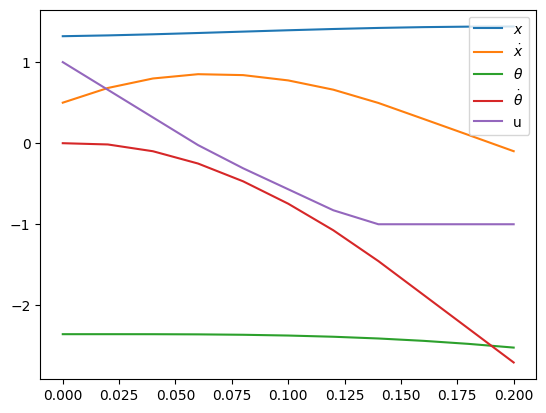

In [ ]:
from scipy.optimize import LinearConstraint, NonlinearConstraint
from control.optimal import OptimalControlProblem
import control.flatsys as fs

high = np.array([0.6*env.x_threshold, 1])

constraints = [
    LinearConstraint(np.array([[1, 0, 0, 0, 0], [0, 0, 0, 0, 1]]), -high, high),
]

P = np.diag([100, 10, 10000, 10])   # get close to final point
traj_cost = obc.quadratic_cost(io_cartpole, P, 0, x0=0)

n_points_predict = 11
T_pred = (n_points_predict - 1) * env.tau
timepts = np.linspace(0, T_pred, n_points_predict, endpoint=True)
n_breakpoints = 4
n_points_control = 11
T_ctrl = (n_points_control - 1) * env.tau
print(T_pred, T_ctrl)
breakpoints = np.linspace(0, T_ctrl, n_breakpoints, endpoint=True)
basis = fs.BSplineFamily(breakpoints = breakpoints, degree = 1)

cartpole_optimal_problem = OptimalControlProblem(
    io_cartpole,
    timepts,
    basis=basis,
    integral_cost=traj_cost,
    trajectory_constraints=constraints,
    minimize_options={"maxiter": 1000},
    minimize_method="SLSQP"
)

result = cartpole_optimal_problem.compute_trajectory(X0)

for mesure, name in zip(result.states, io_cartpole.output_labels):
    plt.plot(result.time, mesure, label=name)
plt.plot(result.time, result.inputs[0], label=io_cartpole.input_labels[0])
plt.legend()
plt.show()

In [ ]:
from control.optimal import OptimalControlProblem
from controlgym.agents import Agent

class MPCDiscreteAgent(Agent):
    def __init__(self, opc_problem: OptimalControlProblem, obs_to_state=lambda x:x):
        self.opc_problem = opc_problem
        self.obs_to_state = obs_to_state
        # self.initial_guess = opc_problem.initial_guess

    def act(self, observation):
        state = self.obs_to_state(observation)
        res = self.opc_problem.compute_trajectory(state, print_summary=False)
        # self.initial_guess = self.opc_problem.initial_guess
        continuous_action = res.inputs[:, 0]
        return int(continuous_action[0] > 0)

    def reset(self):
        self.mpc_io = self.opc_problem.create_mpc_iosystem()

mpc_agent = MPCDiscreteAgent(cartpole_optimal_problem)
observations, actions, times = record_video(env, mpc_agent, steptime=env.tau)

In [ ]:
show_video()